# Stochastic coupled updraft/downdraft modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import sys

import metpy.calc as mpcalc
from metpy.units import units, concatenate

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from coupler import CoupledThermalGenerator
from stochastic_generator import StochasticThermalGenerator

In [2]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
height -= height[-1]
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = CoupledThermalGenerator(
    pressure, height, temperature, specific_humidity)
stochastic = StochasticThermalGenerator(
    pressure, height, temperature, specific_humidity)

## Standard parcel model with random constant entrainment rate

In [18]:
%%time
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
rng = np.random.default_rng(seed=0)
epsilon_up = rng.exponential(scale=0.25, size=100)*(1/units.km)
epsilon_down = rng.exponential(scale=0.25, size=100)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0.5/units.km

updrafts, downdrafts1, downdrafts2, downdrafts3 = generator.ensemble(
    i_init, t_pert, q_pert, l_initial, w_initial,
    epsilon_up, epsilon_down, dnu_db, drag, l_crit, basic=True)

Calculation 100 of 100    
CPU times: user 1min 33s, sys: 246 ms, total: 1min 34s
Wall time: 1min 33s


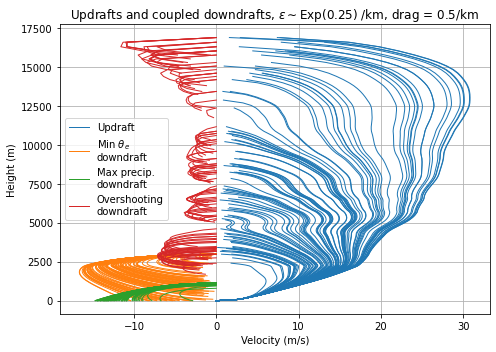

In [19]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft', linewidth=1)
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft', linewidth=1)
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '$\\epsilon \\sim \\mathrm{{Exp}}(0.25)$ /km, drag = 0.5/km')
fig.tight_layout()

## Thoughts
- In an ensemble of updrafts (downdrafts), individual members naturally terminate a while after they encounter negative (positive) buoyancy. Could this be used to model detrainment, rather than the assumption about the bulk detrainment rate being proportional to buoyancy?
- Downdraft initiation level could also be randomly chosen, e.g. normal distribution about the level of minimum $\theta_e$

# Stochastic parcel model

CPU times: user 1.5 s, sys: 25.1 ms, total: 1.53 s
Wall time: 1.51 s


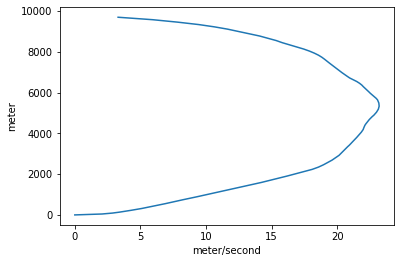

In [43]:
%%time
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
lambda_ = 500*units.meter
sigma = 0.1*units.dimensionless
drag = 0/units.km

updraft = stochastic.updraft(
    i_init, t_pert, q_pert, l_initial, w_initial,
    lambda_, sigma, drag, l_crit, basic=True)

fig, ax = plt.subplots()
ax.plot(updraft.velocity, height)